# EE-411, HomeWork 3 : Neural networks
### Yassin Alnuaimee 326279  EL-MA1

## 1 Backpropagation with logistic loss

### 1)

In [5]:
import numpy as np

In [1]:
def sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

def grad_sigmoid(t):
    """return the derivative of sigmoid on t."""
    return sigmoid(t) * (1 - sigmoid(t))

In [2]:
def predict(X,W):
  W1 = W['w_1']
  W2 = W['w_2']

  z1 = W1.T @ X.T
  x1 = sigmoid(z1)
  z2 = W2.T @ x1
  y_hat = sigmoid(z2)

  return z1, z2, y_hat

### 2)

In [6]:
def logistic_loss(y,y_hat):
  cost = -y*np.log(y_hat) - (np.ones(np.size(y))-y)*np.log(1-y_hat)
  return np.mean(cost)

print(logistic_loss(0,0))

nan


C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_26972\2929021861.py:2: RuntimeWarning: divide by zero encountered in log
  cost = -y*np.log(y_hat) - (np.ones(np.size(y))-y)*np.log(1-y_hat)
C:\Users\Yass La Menace\AppData\Local\Temp\ipykernel_26972\2929021861.py:2: RuntimeWarning: invalid value encountered in scalar multiply
  cost = -y*np.log(y_hat) - (np.ones(np.size(y))-y)*np.log(1-y_hat)


We see that this formula gves an error for $\hat{y}$ and $y=0$

### 3)

In [8]:
def stable_logistic_loss(y,z_2):
  cost = y * np.logaddexp(0,-z_2) - (y - np.ones(np.size(y))) * np.logaddexp(0,z_2)
  return np.mean(cost)

print(stable_logistic_loss(0, -10e10))

0.0


With this new stable logistic formula, we indeed see that the formula gives us the desired output

### 4)

Let's first look at the Loss function : $$ L = y \log(1+ e^{-z_2}) - (y-1) \log(1 + e^{z_2}) $$ with $z_2 = W_2^T x_1$ and $x_1 = σ(W_1^T x_0)$. We can even obatin a direct dependency between $z_2$ and $W_1 $ such that $z_2 = W_2^T σ(W_1^T x_0)$).

We now need to compute the derivative with respect to $W_2$ :

$$ \frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial (z_2/x_1)} = \frac{\partial L}{\partial z_2} x_1$$

Thus we now need to compute the $\frac{\partial L}{\partial z_2}$. We get 
$$\frac{\partial L}{\partial z_2} = -y \cdot \frac{1}{1+e^{z_2}} + (1-y) \cdot \frac{1}{1+e^{-z_2}} = -y \cdot \sigma(-z_2) + (1-y) \cdot \sigma(z_2)$$

We therefore get $$ \frac{\partial L}{\partial W_2} = (-y \cdot \sigma(-z_2) + (1-y) \cdot \sigma(z_2))x_1 $$

Now let's look at $ \frac{\partial L}{\partial W_1}$. Using the chain rule, we have that :
$$ \frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial z_2} \cdot \frac{\partial z_2}{\partial W_1} = \frac{\partial L}{\partial z_2} W_2^T σ'(W_1^T x_0) x_0$$

$$ \frac{\partial L}{\partial W_1} = \left( -y \cdot \sigma(-z_2) + (1-y) \cdot \sigma(z_2) \right) W_2^T σ'(z_1) x_0$$ 
The derivative of the sigmoid function is $σ'(t) = \sigma(t) (1-\sigma(t))$. Hence we get 

$$ \frac{\partial L}{\partial W_1} = \left( -y \cdot \sigma(-z_2) + (1-y) \cdot \sigma(z_2) \right) W_2^T \sigma(z_1) (1-\sigma(z_1)) x_0 $$

To conclude, we have the following gradient :
$$ \frac{\partial L}{\partial W_1} = \left( -y \cdot \sigma(-z_2) + (1-y) \cdot \sigma(z_2) \right) W_2^T \sigma(z_1) (1-\sigma(z_1)) x_0 $$
$$ \frac{\partial L}{\partial W_2} = (-y \cdot \sigma(-z_2) + (1-y) \cdot \sigma(z_2))x_1  $$


### 5)

In [10]:
def gradient(X,y,W):
  
  
  X = X[:,np.newaxis]
  W['w_2'] = W['w_2'][:,np.newaxis]
  x1 = sigmoid(W['w_1'].T @ X)
  z1 = W['w_1'].T@X
  z2 = W['w_2'].T@x1


  dl_dw2 = x1/(1+np.exp(z2)) * (-y -y*np.exp(z2) + np.exp(z2))
  
  dl_dw1 = ((-y * sigmoid(-z2) + (np.ones((np.shape(y)))-y)*sigmoid(z2)) * W['w_2'].T @sigmoid(z1)*(np.ones((np.shape(z1))) - sigmoid(z1))@X.T).T

  return {
        "dl_dw_1": dl_dw1,
        "dl_dw_2": dl_dw2
    }



## 2 classifying KMNSIT using neural networks

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

### 1)

In [3]:
# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([T.ToTensor()])

# load the train dataset

train_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

100.0%


Extracting ./data/KMNIST\raw\train-images-idx3-ubyte.gz to ./data/KMNIST\raw



100.0%


Extracting ./data/KMNIST\raw\train-labels-idx1-ubyte.gz to ./data/KMNIST\raw



100.0%


Extracting ./data/KMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/KMNIST\raw



100.0%

Extracting ./data/KMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/KMNIST\raw

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [4]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

In [7]:
from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

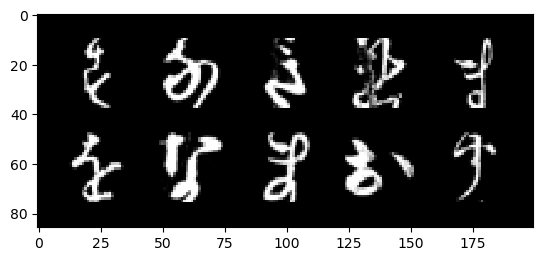

In [8]:
visualize_images(train_dataloader)

### 2)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
class Net(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(500, 10)
        # we also define the non-linearity 
        self.relu = nn.ReLU()



    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # You should (a) transform the a size that is readable
        # by the MLP and (b) pass the the input x successively 
        # through the layers.
        # ***************************************************
        # transform the image to a vector
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        # pass the vectored image through the layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [13]:
# initialize the model
model = Net()

# move model to device
model = model.to(DEVICE)

# define the optimizer
# Hint: https://pytorch.org/docs/stable/optim.html
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [14]:
from typing import Optional

def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

In [16]:
train_losses, valid_losses, valid_accs = fit(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

Epoch 0: Train Loss=0.8876, Validation Loss=0.8869, Validation acc=75.0600
Epoch 1: Train Loss=0.8666, Validation Loss=0.8670, Validation acc=75.2600
Epoch 2: Train Loss=0.8475, Validation Loss=0.8493, Validation acc=75.7900
Epoch 3: Train Loss=0.8300, Validation Loss=0.8328, Validation acc=76.0300
Epoch 4: Train Loss=0.8139, Validation Loss=0.8176, Validation acc=76.4100
Epoch 5: Train Loss=0.7992, Validation Loss=0.8038, Validation acc=76.6600
Epoch 6: Train Loss=0.7858, Validation Loss=0.7909, Validation acc=77.2100
Epoch 7: Train Loss=0.7728, Validation Loss=0.7790, Validation acc=77.5800
Epoch 8: Train Loss=0.7615, Validation Loss=0.7678, Validation acc=77.9300
Epoch 9: Train Loss=0.7502, Validation Loss=0.7574, Validation acc=78.2400
Epoch 10: Train Loss=0.7400, Validation Loss=0.7479, Validation acc=78.4500
Epoch 11: Train Loss=0.7303, Validation Loss=0.7390, Validation acc=78.5600
Epoch 12: Train Loss=0.7215, Validation Loss=0.7303, Validation acc=78.7900
Epoch 13: Train Loss=0

In [19]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 1.0784, Accuracy: 6696/10000 (67%)


(1.0783638488769531, tensor(66.9600))

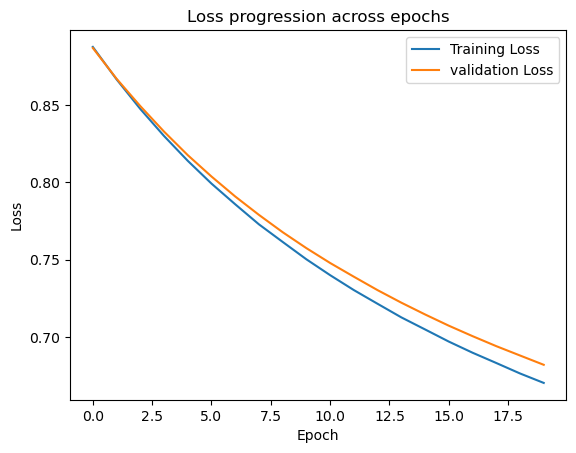

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_losses,label="Training Loss")
plt.plot(valid_losses,label="validation Loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")
plt.legend()

Epoch 0: Train Loss=0.6492, Validation Loss=0.6427, Validation acc=81.1100
Epoch 1: Train Loss=0.6069, Validation Loss=0.6061, Validation acc=82.1700
Epoch 2: Train Loss=0.5740, Validation Loss=0.5804, Validation acc=82.8100
Epoch 3: Train Loss=0.5482, Validation Loss=0.5601, Validation acc=83.4900
Epoch 4: Train Loss=0.5267, Validation Loss=0.5406, Validation acc=84.0400
Epoch 5: Train Loss=0.5073, Validation Loss=0.5245, Validation acc=84.5800
Epoch 6: Train Loss=0.4911, Validation Loss=0.5112, Validation acc=85.0100
Epoch 7: Train Loss=0.4761, Validation Loss=0.5006, Validation acc=85.2200
Epoch 8: Train Loss=0.4626, Validation Loss=0.4871, Validation acc=85.8400
Epoch 9: Train Loss=0.4501, Validation Loss=0.4771, Validation acc=86.0500
Epoch 10: Train Loss=0.4386, Validation Loss=0.4676, Validation acc=86.3200
Epoch 11: Train Loss=0.4281, Validation Loss=0.4584, Validation acc=86.5800
Epoch 12: Train Loss=0.4187, Validation Loss=0.4513, Validation acc=86.8500
Epoch 13: Train Loss=0

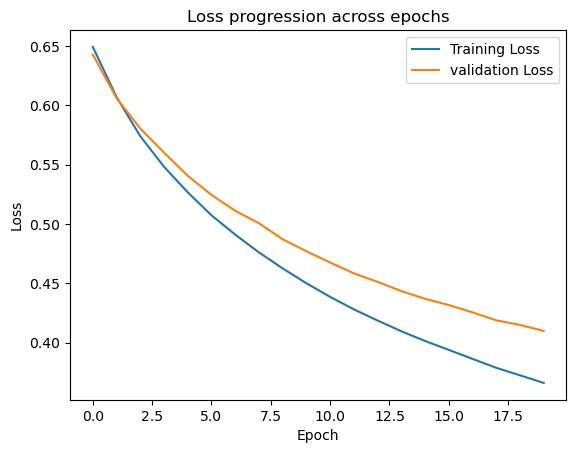

In [23]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

train_losses, valid_losses, valid_accs = fit(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses,label="Training Loss")
plt.plot(valid_losses,label="validation Loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")
plt.legend()

Epoch 0: Train Loss=0.4802, Validation Loss=0.3665, Validation acc=89.2300
Epoch 1: Train Loss=0.2975, Validation Loss=0.3195, Validation acc=90.4000
Epoch 2: Train Loss=0.2531, Validation Loss=0.3047, Validation acc=91.0100
Epoch 3: Train Loss=0.2185, Validation Loss=0.2859, Validation acc=91.3000
Epoch 4: Train Loss=0.1983, Validation Loss=0.2959, Validation acc=91.2100
Epoch 5: Train Loss=0.1803, Validation Loss=0.2927, Validation acc=91.6700
Epoch 6: Train Loss=0.1615, Validation Loss=0.2798, Validation acc=91.6900
Epoch 7: Train Loss=0.1465, Validation Loss=0.2867, Validation acc=92.0300
Epoch 8: Train Loss=0.1342, Validation Loss=0.2868, Validation acc=91.8500
Epoch 9: Train Loss=0.1260, Validation Loss=0.2848, Validation acc=92.1200
Epoch 10: Train Loss=0.1138, Validation Loss=0.2683, Validation acc=92.6300
Epoch 11: Train Loss=0.1041, Validation Loss=0.2742, Validation acc=92.5800
Epoch 12: Train Loss=0.0992, Validation Loss=0.2922, Validation acc=92.1100
Epoch 13: Train Loss=0

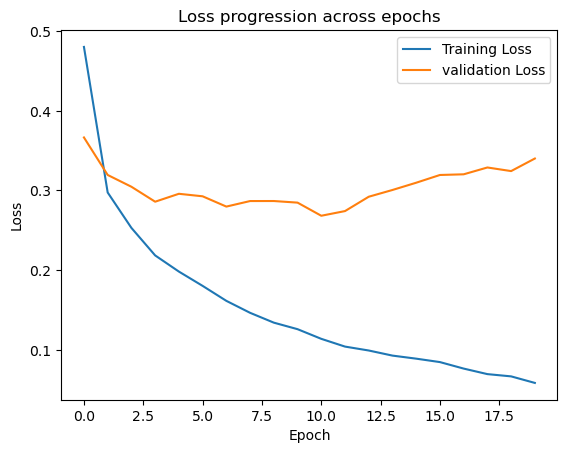

In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses, valid_losses, valid_accs = fit(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses,label="Training Loss")
plt.plot(valid_losses,label="validation Loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")
plt.legend()

Epoch 0: Train Loss=96.7983, Validation Loss=2.3310, Validation acc=10.9400
Epoch 1: Train Loss=2.2870, Validation Loss=2.4145, Validation acc=12.4100
Epoch 2: Train Loss=2.2344, Validation Loss=2.1987, Validation acc=14.0700
Epoch 3: Train Loss=2.3137, Validation Loss=2.2336, Validation acc=13.0800
Epoch 4: Train Loss=2.2249, Validation Loss=2.1990, Validation acc=13.8900
Epoch 5: Train Loss=2.2255, Validation Loss=2.2430, Validation acc=12.5200
Epoch 6: Train Loss=2.2492, Validation Loss=2.2387, Validation acc=12.9300
Epoch 7: Train Loss=2.2223, Validation Loss=2.2239, Validation acc=13.9800
Epoch 8: Train Loss=2.2109, Validation Loss=2.2507, Validation acc=14.2100
Epoch 9: Train Loss=2.2082, Validation Loss=2.2012, Validation acc=14.2500
Epoch 10: Train Loss=2.2139, Validation Loss=2.2426, Validation acc=12.8400
Epoch 11: Train Loss=2.2498, Validation Loss=2.2132, Validation acc=14.1700
Epoch 12: Train Loss=2.2185, Validation Loss=2.2201, Validation acc=13.2500
Epoch 13: Train Loss=

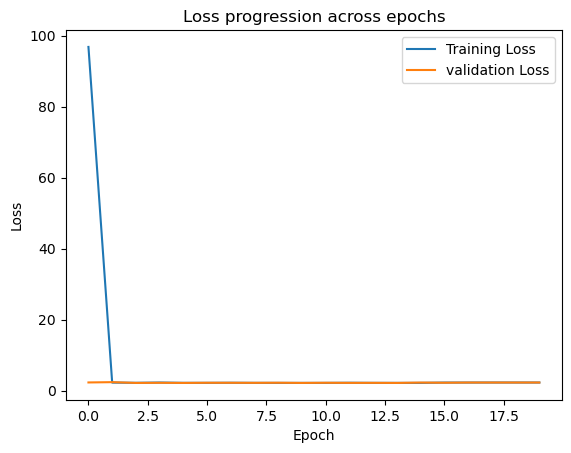

In [25]:
optimizer = optim.Adam(model.parameters(), lr= 1)

train_losses, valid_losses, valid_accs = fit(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses,label="Training Loss")
plt.plot(valid_losses,label="validation Loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")
plt.legend()

### 3)

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(64*3*3, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [30]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = optim.SGD(cnn.parameters(), lr=0.01)

# train the CNN
train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=2.3017, Validation Loss=2.2994, Validation acc=16.2700
Epoch 1: Train Loss=2.2970, Validation Loss=2.2947, Validation acc=18.1200
Epoch 2: Train Loss=2.2918, Validation Loss=2.2890, Validation acc=20.2500
Epoch 3: Train Loss=2.2854, Validation Loss=2.2817, Validation acc=23.1600
Epoch 4: Train Loss=2.2766, Validation Loss=2.2711, Validation acc=26.0900
Epoch 5: Train Loss=2.2629, Validation Loss=2.2537, Validation acc=29.3900
Epoch 6: Train Loss=2.2391, Validation Loss=2.2216, Validation acc=34.5600
Epoch 7: Train Loss=2.1919, Validation Loss=2.1532, Validation acc=43.7700
Epoch 8: Train Loss=2.0836, Validation Loss=1.9892, Validation acc=52.6900
Epoch 9: Train Loss=1.8401, Validation Loss=1.6693, Validation acc=58.6200
Epoch 10: Train Loss=1.5090, Validation Loss=1.3748, Validation acc=61.9100
Epoch 11: Train Loss=1.2700, Validation Loss=1.1945, Validation acc=64.0800
Epoch 12: Train Loss=1.1148, Validation Loss=1.0756, Validation acc=64.3000
Epoch 13: Train Loss=1

(1.0982656311035157, tensor(64.7600))

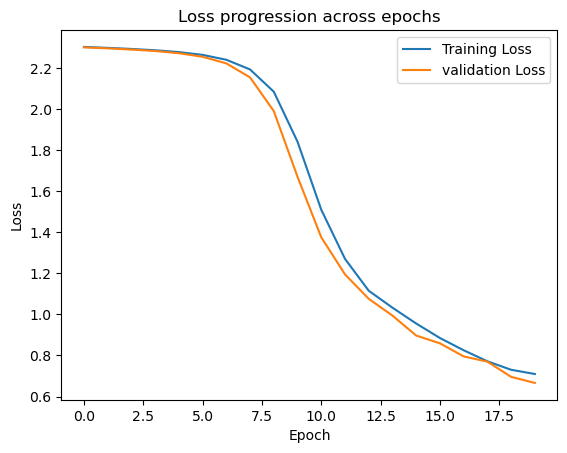

In [31]:
plt.plot(train_losses,label="Training Loss")
plt.plot(valid_losses,label="validation Loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")
plt.legend()

Epoch 0: Train Loss=2.1349, Validation Loss=1.5007, Validation acc=59.1800
Epoch 1: Train Loss=1.0274, Validation Loss=0.7118, Validation acc=76.9600
Epoch 2: Train Loss=0.5907, Validation Loss=0.4981, Validation acc=84.3700
Epoch 3: Train Loss=0.4413, Validation Loss=0.4316, Validation acc=86.2400
Epoch 4: Train Loss=0.3631, Validation Loss=0.3339, Validation acc=89.6100
Epoch 5: Train Loss=0.3095, Validation Loss=0.2960, Validation acc=90.9100
Epoch 6: Train Loss=0.2792, Validation Loss=0.2650, Validation acc=92.0200
Epoch 7: Train Loss=0.2340, Validation Loss=0.2343, Validation acc=92.8700
Epoch 8: Train Loss=0.2101, Validation Loss=0.2523, Validation acc=92.2700
Epoch 9: Train Loss=0.1953, Validation Loss=0.2119, Validation acc=93.7200
Epoch 10: Train Loss=0.1798, Validation Loss=0.1918, Validation acc=94.1500
Epoch 11: Train Loss=0.1663, Validation Loss=0.1851, Validation acc=94.5300
Epoch 12: Train Loss=0.1555, Validation Loss=0.1815, Validation acc=94.5500
Epoch 13: Train Loss=0

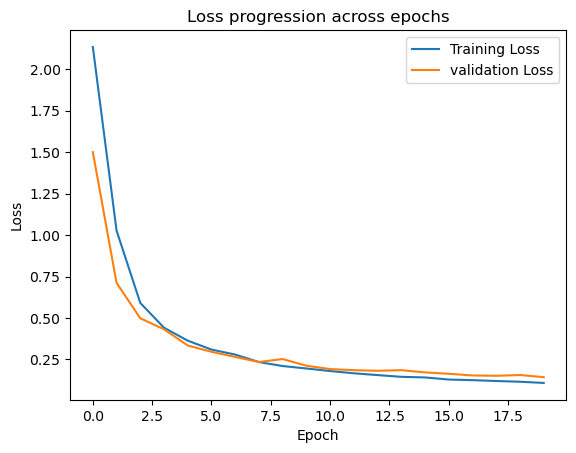

In [32]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = optim.SGD(cnn.parameters(), lr=0.01,momentum=0.9, nesterov=True)

# train the CNN
train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses,label="Training Loss")
plt.plot(valid_losses,label="validation Loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")
plt.legend()

Epoch 0: Train Loss=0.8180, Validation Loss=0.3134, Validation acc=90.1100
Epoch 1: Train Loss=0.2069, Validation Loss=0.1742, Validation acc=94.7000
Epoch 2: Train Loss=0.1283, Validation Loss=0.1201, Validation acc=96.5700
Epoch 3: Train Loss=0.0840, Validation Loss=0.1031, Validation acc=96.7400
Epoch 4: Train Loss=0.0663, Validation Loss=0.0931, Validation acc=97.2100
Epoch 5: Train Loss=0.0590, Validation Loss=0.0951, Validation acc=97.2300
Epoch 6: Train Loss=0.0427, Validation Loss=0.0900, Validation acc=97.4000
Epoch 7: Train Loss=0.0390, Validation Loss=0.0865, Validation acc=97.6300
Epoch 8: Train Loss=0.0283, Validation Loss=0.0898, Validation acc=97.5500
Epoch 9: Train Loss=0.0275, Validation Loss=0.0874, Validation acc=97.8200
Epoch 10: Train Loss=0.0238, Validation Loss=0.0973, Validation acc=97.7700
Epoch 11: Train Loss=0.0180, Validation Loss=0.1049, Validation acc=97.7000
Epoch 12: Train Loss=0.0159, Validation Loss=0.0982, Validation acc=97.9400
Epoch 13: Train Loss=0

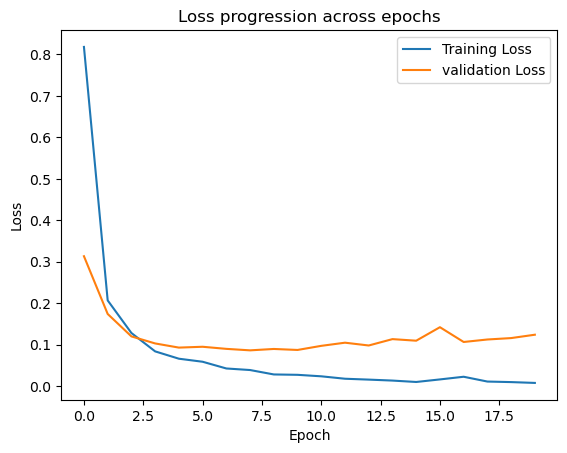

In [34]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = optim.Adam(cnn.parameters(), lr=0.01)

# train the CNN
train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses,label="Training Loss")
plt.plot(valid_losses,label="validation Loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")
plt.legend()

Epoch 0: Train Loss=26273.5290, Validation Loss=2.3320, Validation acc=9.7000
Epoch 1: Train Loss=2.3117, Validation Loss=2.3042, Validation acc=9.7000
Epoch 2: Train Loss=2.3057, Validation Loss=2.3056, Validation acc=9.8000
Epoch 3: Train Loss=2.3073, Validation Loss=2.3066, Validation acc=9.8000
Epoch 4: Train Loss=2.3075, Validation Loss=2.3080, Validation acc=9.8000
Epoch 5: Train Loss=2.3078, Validation Loss=2.3060, Validation acc=10.1300
Epoch 6: Train Loss=2.3072, Validation Loss=2.3119, Validation acc=9.6800
Epoch 7: Train Loss=2.3077, Validation Loss=2.3067, Validation acc=10.0300
Epoch 8: Train Loss=2.3081, Validation Loss=2.3081, Validation acc=9.6800
Epoch 9: Train Loss=2.3075, Validation Loss=2.3083, Validation acc=9.7000
Epoch 10: Train Loss=2.3099, Validation Loss=2.3111, Validation acc=9.7800
Epoch 11: Train Loss=2.3096, Validation Loss=2.3113, Validation acc=9.7000
Epoch 12: Train Loss=2.3090, Validation Loss=2.3136, Validation acc=9.7000
Epoch 13: Train Loss=2.3109, 

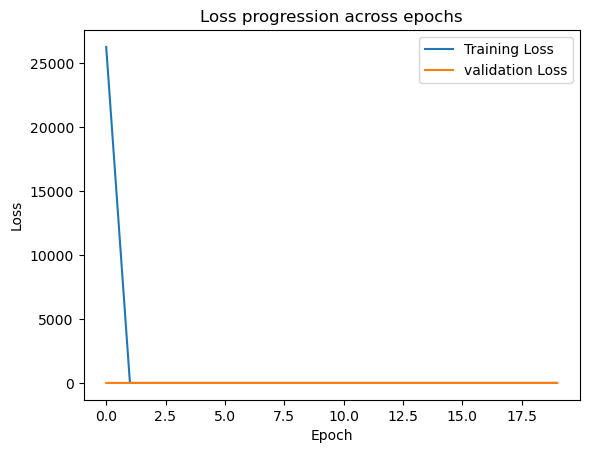

In [36]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = optim.Adam(cnn.parameters(), lr=1)

# train the CNN
train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses,label="Training Loss")
plt.plot(valid_losses,label="validation Loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")
plt.legend()

In [ ]:
-